In [1]:
#Checking versions of sys and scikit-learn
import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__ >= '0.20'

#importing basic libraries
import numpy as np
import os

np.random.seed(42)

#to plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X,y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

28*28 = 784

Saving figure some_digit_plot


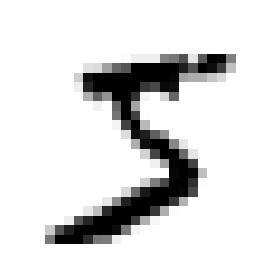

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis('off')

save_fig('some_digit_plot')
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

In [9]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation='nearest')
    plt.axis('off')

In [10]:
def plot_digits(instances, images_per_row=10, **options):
    size=28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances)-1)//images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


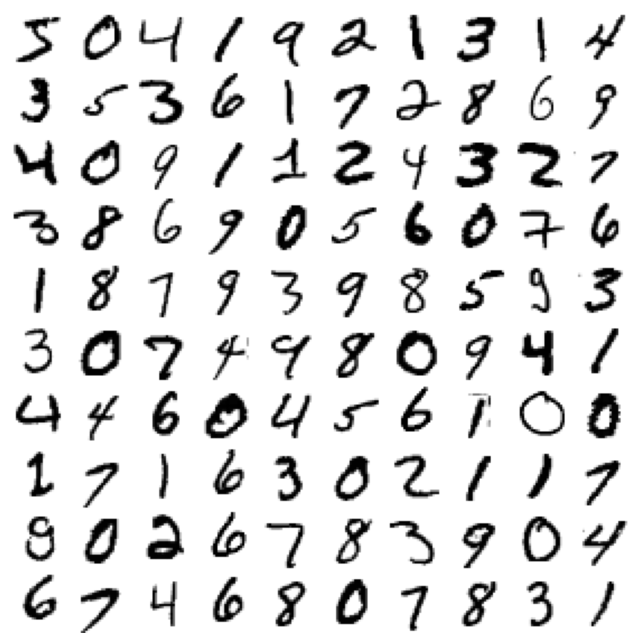

In [11]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images)
save_fig('more_digits_plot')
plt.show()

In [12]:
y[0]

5

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary Classifier

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [16]:
sgd_clf.predict([some_digit])

array([ True])

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [21]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1), dtype=bool)

In [22]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.0997 , 0.0965 , 0.09995])

In [23]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [24]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [25]:
y_train_perfect_predictions = y_train_5  #pretend everything is correct
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [26]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [27]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1,1] / (cm[0,1] + cm[1,1])

0.8370879772350012

In [28]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

In [29]:
cm[1,1]/(cm[1,0]+cm[1,1])

0.6511713705958311

In [30]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [31]:
cm[1,1]/(cm[1,1]+(cm[1,0]+cm[0,1])/2)

0.7325171197343847

In [54]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [55]:
thresholds = 0
y_some_digit_pred = (y_scores>thresholds)

In [56]:
y_some_digit_pred

array([ True])

In [57]:
thresholds = 8000
y_some_digit_pred = (y_scores > thresholds)
y_some_digit_pred

array([False])

In [58]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")


In [59]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


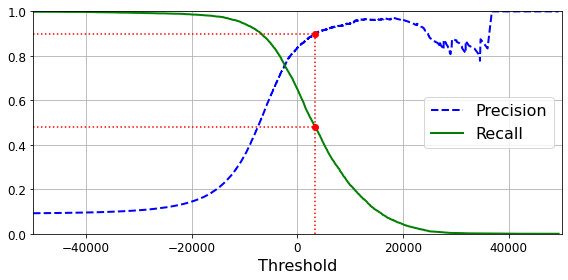

In [60]:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [61]:
(y_train_pred == (y_scores > 0)).all()


True

Saving figure precision_vs_recall_plot


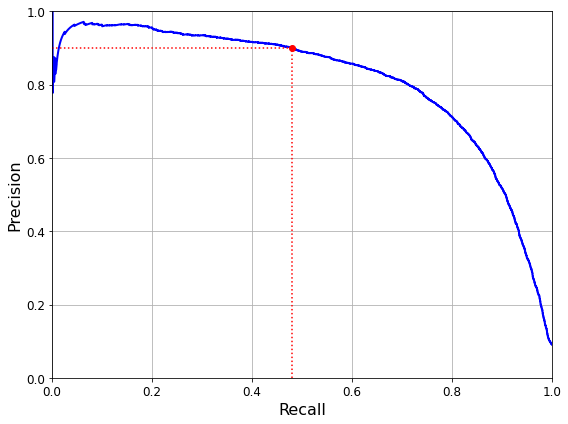

In [62]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [63]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


In [64]:
threshold_90_precision

3370.0194991439557

In [65]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [66]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [67]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [68]:

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


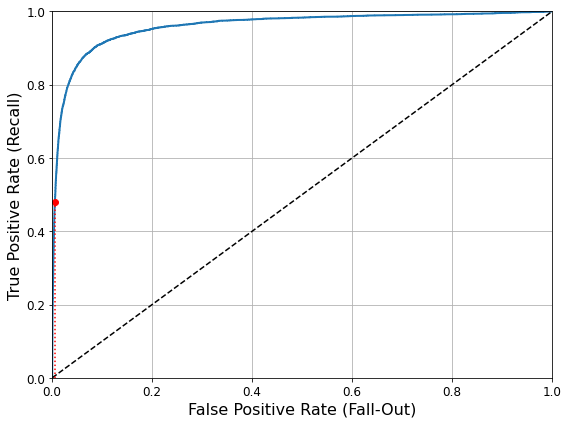

In [69]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [70]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [71]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [72]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


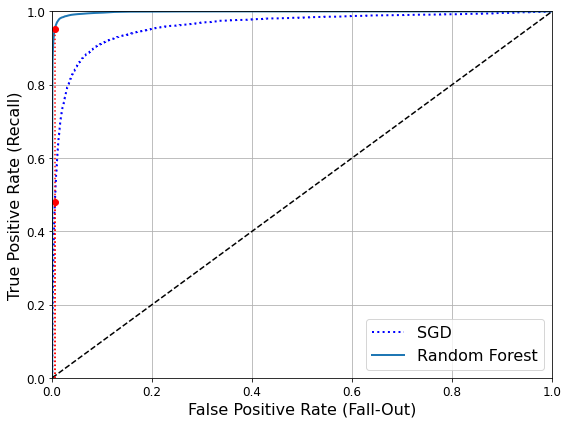

In [73]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [74]:
roc_auc_score(y_train_5, y_scores_forest)


0.9983436731328145

In [75]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [76]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## Multiclass Classification

In [77]:
from sklearn.svm import SVC
svm_clf = SVC(gamma='auto', random_state = 42)
svm_clf.fit(X_train[:1000],y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [78]:
some_digit_score = svm_clf.decision_function([some_digit])
some_digit_score

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [79]:
np.argmax(some_digit_score)

5

In [80]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [81]:
svm_clf.classes_[5]

5

In [82]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma='auto', random_state=42))
ovr_clf.fit(X_train[:1000],y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [83]:
len(ovr_clf.estimators_)

10

In [84]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [85]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [86]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [87]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled,y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [88]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

Saving figure confusion_matrix_plot


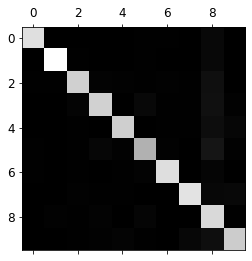

In [89]:
from sklearn.metrics import plot_confusion_matrix
plt.matshow(conf_mx, cmap = plt.cm.gray)
save_fig('confusion_matrix_plot', tight_layout=False)
plt.show()

In [90]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

Saving figure confusion_matrix_errors_plot


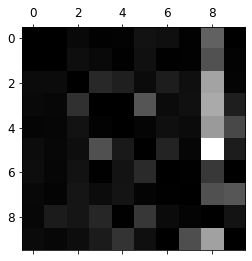

In [91]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
save_fig('confusion_matrix_errors_plot', tight_layout=False)
plt.show()

Saving figure error_analysis_digits_plot


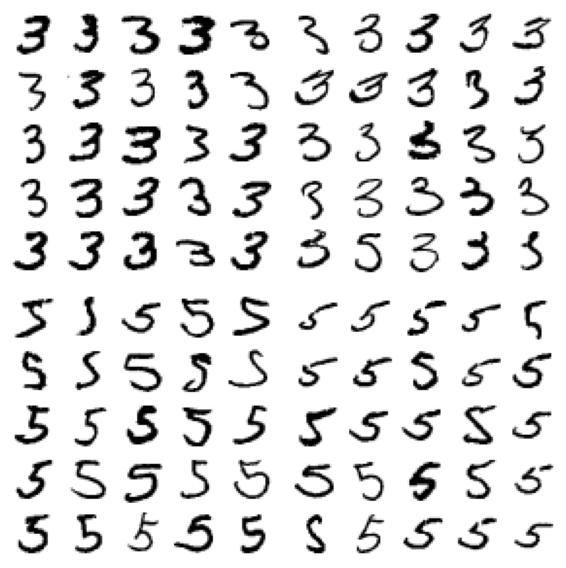

In [92]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

## Multilable Classification

In [93]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [94]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [95]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

## MultiOutput Classification

In [96]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train+noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


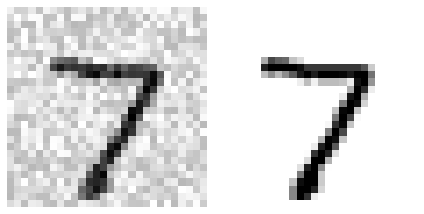

In [97]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


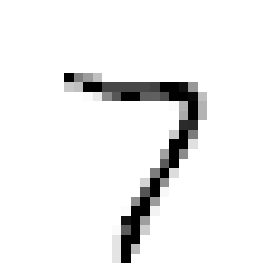

In [98]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

In [99]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier(strategy='prior')
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

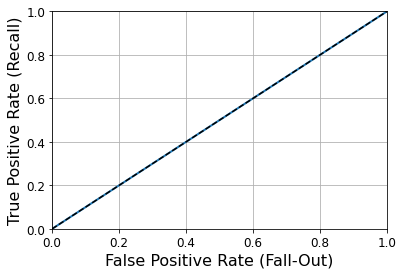

In [100]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

In [101]:

from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [102]:
y_knn_pred = knn_clf.predict(X_test)


In [103]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

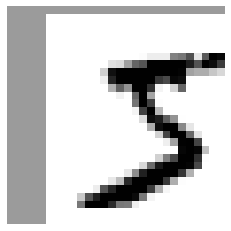

In [104]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [105]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [106]:
knn_clf.fit(X_train_expanded, y_train_expanded)


KNeighborsClassifier(n_neighbors=4, weights='distance')

In [107]:
y_knn_expanded_pred = knn_clf.predict(X_test)


In [108]:
accuracy_score(y_test, y_knn_expanded_pred)


0.9763

In [109]:

ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

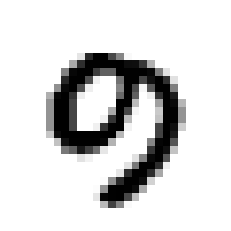

In [110]:
plot_digit(ambiguous_digit)

## Exercise

1. Mnist classifier with over 97% accuracy

In [112]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights':['uniform', 'distance'], 'n_neighbors':[3,4,5]}]

knn_clf = KNeighborsClassifier()

grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose = 3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .................n_neighbors=3, weights=uniform; total time=  13.5s
[CV 2/5] END .................n_neighbors=3, weights=uniform; total time=  12.4s
[CV 3/5] END .................n_neighbors=3, weights=uniform; total time=  12.3s
[CV 4/5] END .................n_neighbors=3, weights=uniform; total time=  12.2s
[CV 5/5] END .................n_neighbors=3, weights=uniform; total time=  12.5s
[CV 1/5] END ................n_neighbors=3, weights=distance; total time=  12.1s
[CV 2/5] END ................n_neighbors=3, weights=distance; total time=  12.3s
[CV 3/5] END ................n_neighbors=3, weights=distance; total time=  12.2s
[CV 4/5] END ................n_neighbors=3, weights=distance; total time=  11.9s
[CV 5/5] END ................n_neighbors=3, weights=distance; total time=  12.2s
[CV 1/5] END .................n_neighbors=4, weights=uniform; total time=  15.3s
[CV 2/5] END .................n_neighbors=4, weig

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [113]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [114]:
grid_search.best_score_

0.9716166666666666

In [115]:
from sklearn.metrics import accuracy_score
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## Data Augmentation

In [116]:
from scipy.ndimage.interpolation import shift

In [117]:
def shift_image(image, dx, dy):
    image = image.reshape((28,28))
    shifted_images = shift(image, [dy,dx], cval=0, mode='constant')

    return shifted_images.reshape([-1])

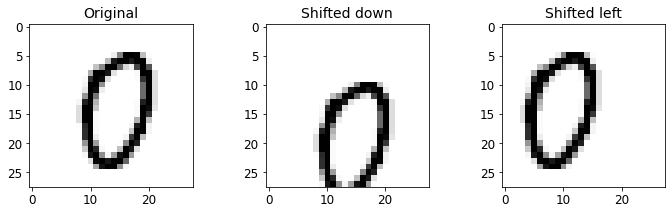

In [119]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [120]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [121]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [122]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)


In [123]:
knn_clf.fit(X_train_augmented, y_train_augmented)


KNeighborsClassifier(n_neighbors=4, weights='distance')

In [124]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

## Remaining two tasks